In [ ]:
!pip install -q transformers accelerate bitsandbytes datasets pandas numpy statsmodels scikit-learn matplotlib seaborn tqdm streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 41.4 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "mistralai/Mistral-7B-Instruct-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [ ]:
from datasets import load_dataset

dataset = load_dataset("gsm8k", "main")
questions = dataset["test"].select(range(12))

def extract_answer(ans):
    return ans.split("####")[-1].strip()

data = []
for i, item in enumerate(questions):
    data.append({
        "question_id": i,
        "question": item["question"],
        "answer": extract_answer(item["answer"])
    })

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
import itertools
import pandas as pd

factors = ["role", "cot", "fewshot", "constraint"]

# Generate full design
design = list(itertools.product([0,1], repeat=4))
df_design = pd.DataFrame(design, columns=factors)

# Balanced reduction
df_design = df_design.sample(8, random_state=42).reset_index(drop=True)
df_design

,role,cot,fewshot,constraint
0,0,0,0,0
1,0,0,0,1
2,0,1,0,1
3,1,1,1,0
4,1,1,0,1
5,1,0,1,1
6,1,0,0,0
7,1,0,0,1


In [ ]:
FEWSHOT_EXAMPLE = """
Q: If 2+2=?
A: 4
"""

def build_prompt(q, role, cot, fewshot, constraint):
    prompt = ""

    if role:
        prompt += "You are a careful mathematical reasoning assistant.\n"

    if fewshot:
        prompt += FEWSHOT_EXAMPLE + "\n"

    prompt += f"Question: {q}\n"

    if cot:
        prompt += "Think step by step.\n"

    if constraint:
        prompt += "Return only the final numeric answer.\n"

    return prompt

In [ ]:
import time
from tqdm import tqdm

results = []

for item in data:
    for _, cond in df_design.iterrows():

        prompt = build_prompt(
            item["question"],
            cond.role,
            cond.cot,
            cond.fewshot,
            cond.constraint
        )

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        input_tokens = inputs.input_ids.shape[1]

        start = time.time()

        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0
        )

        latency = time.time() - start

        output_tokens = outputs.shape[1] - input_tokens
        total_tokens = outputs.shape[1]

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        pred = decoded.split("\n")[-1].strip()

        correct = int(item["answer"] in pred)

        results.append({
            "question_id": item["question_id"],
            "role": cond.role,
            "cot": cond.cot,
            "fewshot": cond.fewshot,
            "constraint": cond.constraint,
            "correct": correct,
            "latency": latency,
            "input_tokens": input_tokens,
            "output_tokens": output_tokens,
            "total_tokens": total_tokens
        })

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for ope

In [ ]:
df = pd.DataFrame(results)
df.to_csv("causal_prompt_results.csv", index=False)

In [ ]:
import statsmodels.formula.api as smf

model_acc = smf.ols(
    "correct ~ role + cot + fewshot + constraint + C(question_id)",
    data=df
).fit()

print(model_acc.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     7.682
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           2.85e-10
Time:                        07:56:54   Log-Likelihood:                -8.5944
No. Observations:                  96   AIC:                             49.19
Df Residuals:                      80   BIC:                             90.22
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1604 

In [ ]:
import numpy as np

boot_coefs = []

for _ in range(1000):
    sampled_ids = np.random.choice(df.question_id.unique(),
                                    size=12,
                                    replace=True)
    boot_df = pd.concat([
        df[df.question_id == i] for i in sampled_ids
    ])

    m = smf.ols(
        "correct ~ role + cot + fewshot + constraint + C(question_id)",
        data=boot_df
    ).fit()

    boot_coefs.append(m.params)

boot_df = pd.DataFrame(boot_coefs)
ci = boot_df.quantile([0.025, 0.975])
ci

,Intercept,C(question_id)[T.1],C(question_id)[T.4],C(question_id)[T.5],C(question_id)[T.6],C(question_id)[T.7],C(question_id)[T.10],role,cot,fewshot,constraint,C(question_id)[T.2],C(question_id)[T.8],C(question_id)[T.11],C(question_id)[T.3],C(question_id)[T.9]
0.025,0.029844,0.875,-0.375,-1.000000e+00,-0.875,-1.000000e+00,-0.75,-0.305556,0.004167,0.044444,-0.116667,-1.000,-1.000000e+00,-1.000000e+00,-0.75,-0.75
0.975,1.093872,0.875,0.625,7.730886e-17,0.125,1.373737e-16,0.25,-0.055556,0.379167,0.252847,0.008333,-0.125,1.648129e-16,1.982020e-16,0.25,0.25


In [ ]:
model_tokens = smf.ols(
    "total_tokens ~ role + cot + fewshot + constraint + C(question_id)",
    data=df
).fit()
print(model_tokens.summary())

                            OLS Regression Results                            
Dep. Variable:           total_tokens   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     10.14
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           5.39e-13
Time:                        07:57:29   Log-Likelihood:                -525.25
No. Observations:                  96   AIC:                             1082.
Df Residuals:                      80   BIC:                             1124.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               88.6528 

In [ ]:
model_latency = smf.ols(
    "latency ~ role + cot + fewshot + constraint + C(question_id)",
    data=df
).fit()
print(model_latency.summary())

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     6.981
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           2.03e-09
Time:                        07:57:39   Log-Likelihood:                -300.44
No. Observations:                  96   AIC:                             632.9
Df Residuals:                      80   BIC:                             673.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.9341 

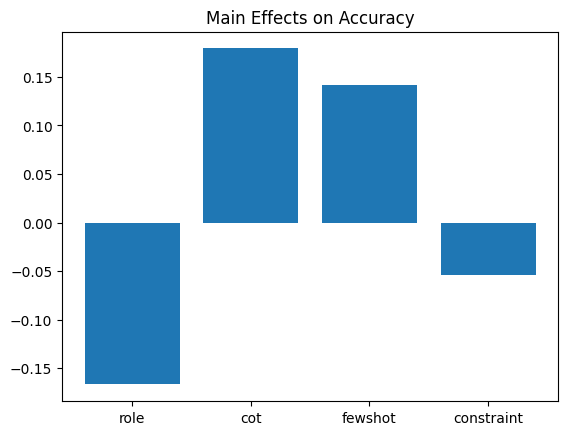

In [ ]:
import matplotlib.pyplot as plt

effects = model_acc.params[["role","cot","fewshot","constraint"]]

plt.bar(effects.index, effects.values)
plt.title("Main Effects on Accuracy")
plt.show()

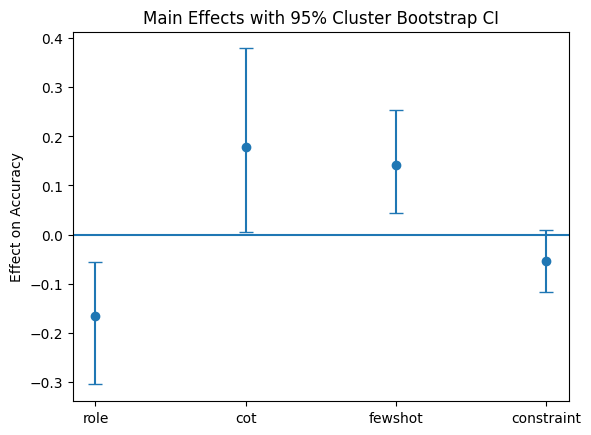

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Main coefficients
coef = model_acc.params[["role","cot","fewshot","constraint"]]

# Bootstrap CI (from your ci dataframe)
lower = ci.loc[0.025, ["role","cot","fewshot","constraint"]]
upper = ci.loc[0.975, ["role","cot","fewshot","constraint"]]

errors = [coef - lower, upper - coef]

plt.figure()
plt.errorbar(coef.index, coef.values,
             yerr=errors,
             fmt='o',
             capsize=5)

plt.axhline(0)
plt.title("Main Effects with 95% Cluster Bootstrap CI")
plt.ylabel("Effect on Accuracy")
plt.show()

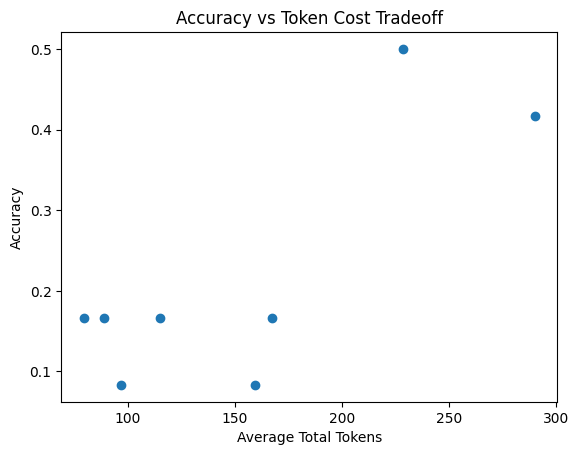

In [ ]:
import matplotlib.pyplot as plt

agg = df.groupby(["role","cot","fewshot","constraint"]).agg({
    "correct":"mean",
    "total_tokens":"mean"
}).reset_index()

plt.figure()
plt.scatter(agg["total_tokens"], agg["correct"])

plt.xlabel("Average Total Tokens")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Token Cost Tradeoff")

plt.show()

In [ ]:
model_inter = smf.ols(
    "correct ~ role*cot + role*fewshot + cot*fewshot + constraint + C(question_id)",
    data=df
).fit()

print(model_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     7.639
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           1.08e-10
Time:                        08:00:25   Log-Likelihood:                -4.3678
No. Observations:                  96   AIC:                             44.74
Df Residuals:                      78   BIC:                             90.89
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0937 

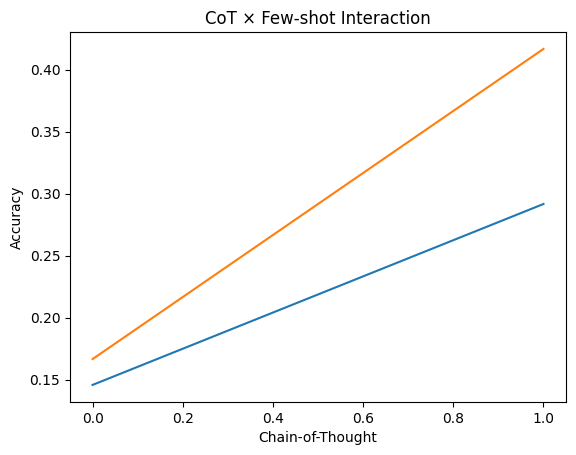

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

interaction = df.groupby(["cot","fewshot"])["correct"].mean().unstack()

plt.figure()
plt.plot(interaction.index, interaction[0])
plt.plot(interaction.index, interaction[1])
plt.xlabel("Chain-of-Thought")
plt.ylabel("Accuracy")
plt.title("CoT × Few-shot Interaction")
plt.show()

In [ ]:
model_inter_cluster = smf.ols(
    "correct ~ cot*fewshot + role + constraint + C(question_id)",
    data=df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["question_id"]}
)

print(model_inter_cluster.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     2.643
Date:                Sat, 21 Feb 2026   Prob (F-statistic):              0.101
Time:                        08:03:24   Log-Likelihood:                -8.5647
No. Observations:                  96   AIC:                             51.13
Df Residuals:                      79   BIC:                             94.72
Df Model:                          16                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1562 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 3
  warnings.warn('covariance of constraints does not have full '


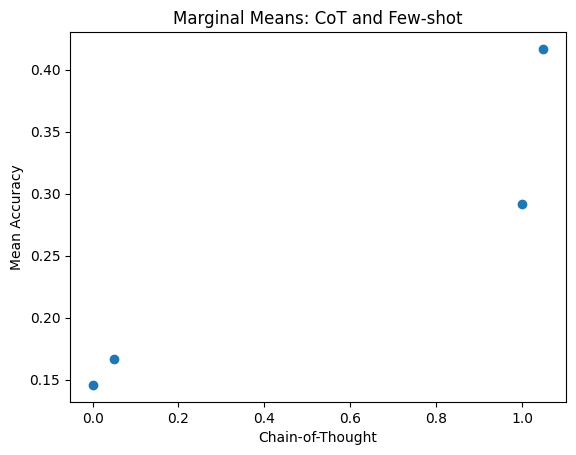

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

means = df.groupby(["cot","fewshot"])["correct"].mean().reset_index()

x = means["cot"]
y = means["correct"]

plt.figure()
plt.scatter(x + means["fewshot"]*0.05, y)
plt.xlabel("Chain-of-Thought")
plt.ylabel("Mean Accuracy")
plt.title("Marginal Means: CoT and Few-shot")
plt.show()

In [ ]:
model_tokens_cluster = smf.ols(
    "total_tokens ~ cot + fewshot + role + constraint + C(question_id)",
    data=df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["question_id"]}
)

print(model_tokens_cluster.summary())

                            OLS Regression Results                            
Dep. Variable:           total_tokens   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     71.53
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           8.43e-08
Time:                        08:04:47   Log-Likelihood:                -525.25
No. Observations:                  96   AIC:                             1082.
Df Residuals:                      80   BIC:                             1124.
Df Model:                          15                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               88.6528 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [ ]:
model_latency_cluster = smf.ols(
    "latency ~ cot + fewshot + role + constraint + C(question_id)",
    data=df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["question_id"]}
)

print(model_latency_cluster.summary())

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     49.81
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           5.57e-07
Time:                        08:05:26   Log-Likelihood:                -300.44
No. Observations:                  96   AIC:                             632.9
Df Residuals:                      80   BIC:                             673.9
Df Model:                          15                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.9341 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [ ]:
df["accuracy_per_token"] = df["correct"] / df["total_tokens"]
df["accuracy_per_second"] = df["correct"] / df["latency"]

eff = df.groupby(["cot","fewshot","role","constraint"]).agg({
    "correct":"mean",
    "total_tokens":"mean",
    "latency":"mean",
    "accuracy_per_token":"mean",
    "accuracy_per_second":"mean"
}).reset_index()

eff.sort_values("accuracy_per_token", ascending=False).head()

,cot,fewshot,role,constraint,correct,total_tokens,latency,accuracy_per_token,accuracy_per_second
5,1,0,0,1,0.500000,228.583333,14.350870,0.003313,0.164160
0,0,0,0,0,0.166667,79.416667,1.543728,0.002645,0.104672
1,0,0,0,1,0.166667,88.833333,1.337254,0.002283,0.131358
2,0,0,1,0,0.166667,167.416667,8.563085,0.002184,0.102615
7,1,1,1,0,0.416667,290.250000,18.413250,0.001706,0.025513


In [ ]:
eff.sort_values("correct", ascending=False).head()

,cot,fewshot,role,constraint,correct,total_tokens,latency,accuracy_per_token,accuracy_per_second
5,1,0,0,1,0.500000,228.583333,14.350870,0.003313,0.164160
7,1,1,1,0,0.416667,290.250000,18.413250,0.001706,0.025513
0,0,0,0,0,0.166667,79.416667,1.543728,0.002645,0.104672
1,0,0,0,1,0.166667,88.833333,1.337254,0.002283,0.131358
4,0,1,1,1,0.166667,114.833333,1.343781,0.001604,0.099724


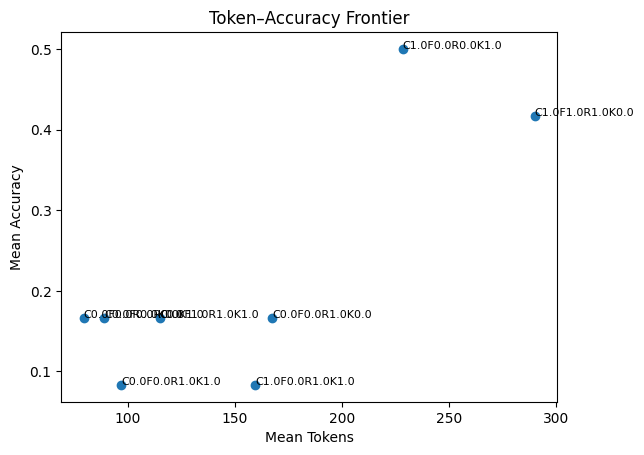

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(eff["total_tokens"], eff["correct"])

for i, row in eff.iterrows():
    label = f"C{row.cot}F{row.fewshot}R{row.role}K{row.constraint}"
    plt.annotate(label, (row["total_tokens"], row["correct"]), fontsize=8)

plt.xlabel("Mean Tokens")
plt.ylabel("Mean Accuracy")
plt.title("Token–Accuracy Frontier")
plt.show()

In [ ]:
from google.colab import files
files.download("causal_prompt_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>